In [2]:
# Author: Davide Aloi - PhD student - University of Birmingham
# The script loads the electrode and / or cod liver oil masks and subtract them from the 
# T1 scan. This is done to remove electrodes / paste / cod liver oil from the t1s, as roast,
# was segmenting them as skull.
# The script also saves a txt file in each participants' folder, with the coordinates of the 
# anodal and cathodal electrodes.

In [3]:
import numpy as np
import nilearn
import os
import glob

main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' 
output_folder = 'D:\\roast-chapter3\\wp_all_results\\' # where to save results
data_folder = 'D:\\roast-chapter3\\'

# Datasets names and subjects lists
db_names = ['wp2a']

# List of coordinates for each subject (return electrode: cathodal, active electrode: anodal)
cath_coords = {
            '01': (140,188,185),
            '02': (133,192,182),
            '03': (127,207,195),
            '04': (139,195,180),
            '06': (135,186,188),
            '07': (142,183,196),
            '08': (148,182,188),
            '09': (142,186,187),
            '10': (151,180,182),
            '11': (149,189,179),
            '12': (146,185,189),
            '13': (145,191,189),
            '14': (131,186,202),
            '15': (134,192,193),
            '16': (133,185,193),
            '17': (133,185,190),
            '18': (140,190,185),
            '19': (158,183,172),
            '20': (156,174,190),
            '22': (147,179,181),
            '23': (142,187,180),
            '24': (132,182,190)
}
anod_coords = {
            '01': (70,85,221),
            '02': (49,99,211),
            '03': (37,98,200),
            '04': (38,109,197),
            '06': (36,86,189),
            '07': (46,75,213),
            '08': (40,75,193),
            '09': (37,88,194),
            '10': (40,75,190),
            '11': (49,81,211),
            '12': (49,66,203),
            '13': (49,94,216),
            '14': (46,60,209),
            '15': (36,73,199),
            '16': (47,76,204),
            '17': (40,83,204),
            '18': (46,99,216),
            '19': (28,97,190),
            '20': (40,72,198),
            '22': (46,94,210),
            '23': (44,93,207),
            '24': (37,95,199)
}



0it [00:00, ?it/s]

D:\roast-chapter3\wp2a\sub-02


1it [00:09,  9.92s/it]


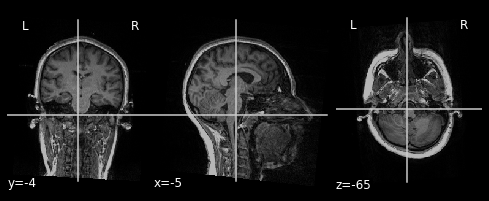

In [4]:
from nilearn import image
from skimage import measure
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from tqdm import tqdm

# list of subjects with cod-liver oil in T1
db_subjects = [['02','03','04','06','07','08','09','10','11','12','13','15','16','17','18','19','20','22','23','24']] 
db_subjects = [['02']] 

for db_id, db in enumerate(db_names): # Iterate all three datasets
    db_path = os.path.join(data_folder, db) # Dataset folder

    for i, subject in tqdm(enumerate(db_subjects[db_id])): #Iterate all subjects
        path = db_path + '\sub-' + subject # Subject folder
        print(path)

        # T1 without cod liver oil (if there was a cod liver oil in the t1)
        T1 = glob.glob(path + '\sub-*T1*withoutcdl.nii')
        # otherwise load the raw T1
        if T1:
            T1 = image.load_img(T1)
        else:
            T1 = image.load_img(glob.glob(path + '\sub-*T1.nii'))

        T1 = new_img_like(T1, T1.get_fdata()[:,:,:,0])

        # electrode mask, segmented with JTK-snap
        el_mask = image.load_img(glob.glob(path + '\\t1_elect_mask.nii'))
        el_mask = new_img_like(el_mask, el_mask.get_fdata()[:,:,:,0])
        el_mask_reversed = np.where(el_mask.get_fdata() == 0, 1, 0)
        
        # This is very inefficient but I don't care now
        import time
        import random
        noise = np.random.randint(10,70,el_mask.get_fdata().size)
        noise = noise.reshape(el_mask_reversed.shape)

        T1_cleaned = T1.get_fdata()*el_mask_reversed #Applying mask
        T1_cleaned = np.where(T1_cleaned == 0, noise, T1_cleaned)
    
        plot_anat(new_img_like(T1, T1_cleaned))
        new_img_like(T1, T1_cleaned).to_filename(path + '\\T1_cleaned.nii')

1it [02:00, 120.79s/it]


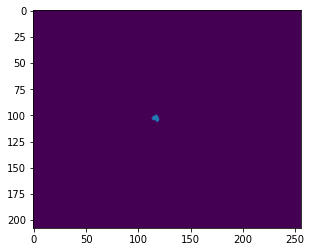

In [5]:
# Final touch up.
# this loops opens t1_cleaned (raw t1s without the electrodes) and sets to 0 all the values
# that are outide of the head.

import skimage
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import clear_output

from nilearn import image
from skimage import measure
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from tqdm import tqdm

# list of subjects with cod-liver oil in T1
db_subjects = [['02','03','04','06','07','08','09','10','11','12','13','15','16','17','18','19','20','22','23','24']] 
db_subjects = [['02']]
for db_id, db in enumerate(db_names): # Iterate all three datasets
     db_path = os.path.join(data_folder, db) # Dataset folder

     for i, subject in tqdm(enumerate(db_subjects[db_id])): #Iterate all subjects
          path = db_path + '\sub-' + subject # Subject folder
          print(path)

          # T1 without cod liver oil (if there was a cod liver oil in the t1)
          T1 = image.load_img(glob.glob(path + '\T1_cleaned.nii'))
          T1_cleaned =  T1.get_fdata()[:,:,:,0]  

          T1_cleaned_bin = np.where(T1_cleaned > 200, 1, 0)
          masked_brain = np.zeros(T1_cleaned_bin.shape)

          for slice in range(0, 255):
               
               x = T1_cleaned_bin[:,:, slice]
               #plt.imshow(x, cmap=plt.cm.gray)
               plt.show()

               contours = measure.find_contours(x, 0.1)

               # Display the image and plot all contours found
               maxind = 0
               max = 0
               for i, contour in enumerate(contours):
                    if contour.size > max:
                         max = contour.size
                         maxind = i

               if len(contours) != 0:
                    mask = np.where(measure.grid_points_in_poly([208,256], contours[maxind][:,:]), 1, 0)
                    mask = skimage.morphology.binary_dilation(mask)
                    mask = skimage.morphology.binary_dilation(mask)
               else:
                    mask = np.zeros(x.shape)
               
               x = np.where(mask == 1,  T1_cleaned[:,:, slice], 0)
               masked_brain[:,:,slice] = x
               plt.imshow(x)
               #plt.imshow(mask)
               if len(contours) != 0:
                    plt.plot(contours[maxind][:, 1], contours[maxind][:, 0], linewidth=2)

               clear_output(wait=True)

          new_img_like(T1, masked_brain).to_filename(path + '\\T1_cleaned.nii')

In [ ]:
# Saving txt files with electrode coordinates.
db_subjects = [['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']] 

for db_id, db in enumerate(db_names): # Iterate all three datasets
    db_path = os.path.join(data_folder, db) # Dataset folder

    for i, subject in tqdm(enumerate(db_subjects[db_id])): #Iterate all subjects
        path = db_path + '\sub-' + subject # Subject folder
        print(path)
        fname = 'customLocations.txt'
        anod = anod_coords[subject]
        cath = cath_coords[subject]
        with open(path + '\\' + fname, 'w') as f:
            f.write('custom1 ' + str(anod[0]) + ' ' + str(anod[1]) + ' ' + str(anod[2]))
            f.writelines('\n')
            f.write('custom2 ' + str(cath[0]) + ' ' + str(cath[1]) + ' ' + str(cath[2]))

22it [00:00, 1297.47it/s]

D:\roast-chapter3\wp2a\sub-01
D:\roast-chapter3\wp2a\sub-02
D:\roast-chapter3\wp2a\sub-03
D:\roast-chapter3\wp2a\sub-04
D:\roast-chapter3\wp2a\sub-06
D:\roast-chapter3\wp2a\sub-07
D:\roast-chapter3\wp2a\sub-08
D:\roast-chapter3\wp2a\sub-09
D:\roast-chapter3\wp2a\sub-10
D:\roast-chapter3\wp2a\sub-11
D:\roast-chapter3\wp2a\sub-12
D:\roast-chapter3\wp2a\sub-13
D:\roast-chapter3\wp2a\sub-14
D:\roast-chapter3\wp2a\sub-15
D:\roast-chapter3\wp2a\sub-16
D:\roast-chapter3\wp2a\sub-17
D:\roast-chapter3\wp2a\sub-18
D:\roast-chapter3\wp2a\sub-19
D:\roast-chapter3\wp2a\sub-20
D:\roast-chapter3\wp2a\sub-22
D:\roast-chapter3\wp2a\sub-23
D:\roast-chapter3\wp2a\sub-24
